In [1]:
%matplotlib inline

from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

import hgail.misc.utils
import hgail.misc.simulation

import utils

In [2]:
# build session
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
# load params, args, env, policy
#params_filepath = '/data/akvasov/ngsim_env/data/experiments/rails_smoothed_infogail_2000_2_fine/imitate/log/itr_88.npz'
params_filepath ='/data/akvasov/ngsim_env/data/experiments/NGSIM-gail/imitate/log/itr_999.npz'
params = hgail.misc.utils.load_params(params_filepath)
#args_filepath = "/data/akvasov/ngsim_env/data/experiments/rails_smoothed_infogail_2000_2_fine/imitate/log/args.npz"
args_filepath ='/data/akvasov/ngsim_env/data/experiments/NGSIM-gail/imitate/log/args.npz'
args = np.load(args_filepath)['args'].item()
env, _, _ = utils.build_ngsim_env(args, exp_dir='/tmp', alpha=0.)
normalizing_env = hgail.misc.utils.extract_normalizing_env(env)
normalizing_env._obs_mean = params['normalzing']['obs_mean']
normalizing_env._obs_var = params['normalzing']['obs_var']

/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


In [ ]:
args.use_infogail

In [ ]:
# load policy params
args.scheduler_k = 40
policy = utils.build_policy(args, env)
sess.run(tf.global_variables_initializer())
policy.set_param_values(params['policy'])

In [ ]:
offset = 365
egoid = 2000
x = env.reset(offset=offset, egoid=egoid)
_,_,_,info = env.step(np.array([0.,0.]))
static_camera_pos = [info['x'], info['y']]
img = env.render(egocolor=[0.,0.,1.])
plt.figure(figsize=(12,12))
plt.imshow(img)

In [22]:
cmap = {
    0:[1.,0.,1.],
    1:[1.,0.,0.],
    2:[0.,0.,1.],
    3:[1.,1.,1.]
}   
def simulate(env, policy, max_steps, render=False, camtype='follow', static_camera_pos=[0.,0.], env_kwargs=dict()):
    traj = hgail.misc.simulation.Trajectory()
    x = env.reset(**env_kwargs)
    policy.reset()
    imgs = []
    print(env_kwargs)
    for step in range(max_steps):
        a, a_info = policy.get_action(x)
        nx, r, done, e_info = env.step(a)
        if render: 
            c = cmap[np.argmax(a_info['latent'])]
            img = env.render(egocolor=c, camtype=camtype, static_camera_pos=static_camera_pos)
            imgs.append(img)
        traj.add(
            policy.observation_space.flatten(x), 
            a, 
            r, 
            a_info,
            e_info
        )
        if done: break
        x = nx
    return traj.flatten(), imgs

In [25]:
n_traj = 1
trajlist = []
imgslist = []
env.reset()
for traj_idx in range(n_traj):
    sys.stdout.write('\r{} / {}'.format(traj_idx + 1, n_traj))
    traj, imgs = simulate(
        env, 
        policy, 
        max_steps=args.scheduler_k, 
        render=True, 
        camtype='follow',
        static_camera_pos=static_camera_pos,
        env_kwargs=dict(offset=offset)#, egoid=egoid)
    )
    trajlist.append(traj)
    imgslist.append(imgs)

1 / 1{'offset': 365}


ValueError: Cannot feed value of shape (1, 2646) for Tensor 'policy/flat_input:0', which has shape '(?, 72)'

In [24]:
imgslist = np.array(imgslist)
imgs = imgslist.mean(0)
imgs.shape

/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


()

In [10]:
fig, ax = plt.subplots(figsize=(16,16))
img = plt.imshow(imgs[0])

def animate(i):
    img.set_data(imgs[i])
    return (img,)

anim = animation.FuncAnimation(
    fig, 
    animate, 
    frames=args.scheduler_k, 
    interval=100, 
    blit=True
)

HTML(anim.to_html5_video())

NameError: name 'imgs' is not defined

In [14]:
latents = []
xs = []
ys = []
ss = []
phis = []
for traj in trajlist:
    latents.append(np.argmax(traj['latent'], axis=1))
    xs.append(traj['x'] - traj['x'][0])
    ys.append(traj['y'] - traj['y'][0])
    ss.append(traj['s'])
    phis.append(traj['phi'])


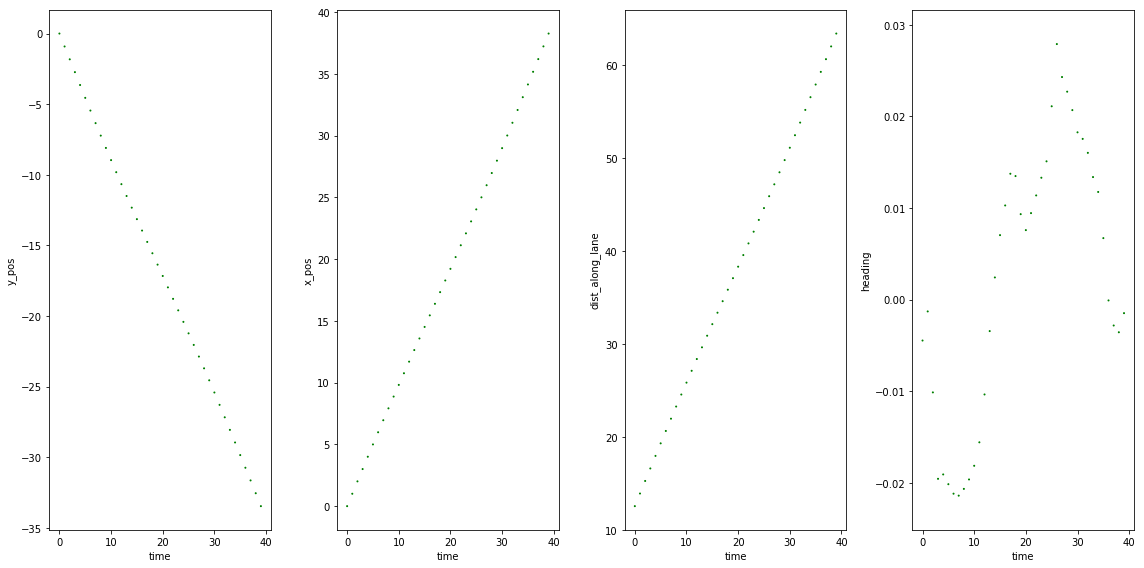

In [17]:
cmap = {
    0:'purple',
    1:'red',
    2:'blue',
    3:'green'
}   
colors = [[cmap[v] for v in latents[i]] for i in range(len(xs))]
labels = ['y_pos', 'x_pos', 'dist_along_lane', 'heading']
plt.figure(figsize=(16,8))
for j, vs in enumerate([ys, xs, ss, phis]):
    plt.subplot(1,4,j+1)
    plt.xlabel('time')
    plt.ylabel(labels[j])
    for i in range(len(xs)):
        plt.scatter(range(len(vs[i])), vs[i], c=colors[i], s=1)
plt.legend()
plt.tight_layout()
plt.show()